In [101]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# !pip install nltk
import nltk
# nltk.download('punkt')

import seaborn as sns
from nltk.stem.porter import PorterStemmer
# nltk.download('stopwords')

# to show stopwords (words only used for framing sentence)
from nltk.corpus import stopwords
import string

# !pip install wordcloud
from wordcloud import WordCloud

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

# !pip install xgboost

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df = pd.read_csv('spam.csv', encoding='latin')


In [33]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
931,ham,Congratulations ore mo owo re wa. Enjoy it and...,NaN,NaN,NaN
4495,ham,"In case you wake up wondering where I am, I fo...",NaN,NaN,NaN
268,ham,The evo. I just had to download flash. Jealous?,NaN,NaN,NaN
1649,ham,ITS A LAPTOP TAKE IT WITH YOU.,NaN,NaN,NaN
38,ham,Anything lor... U decide...,NaN,NaN,NaN


## 1 data cleaning

In [16]:
# no of rows in dataset
df.shape

(5572, 5)

In [34]:
# to check null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [12]:
# dropping last 3 columns cuz too many missing values
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [13]:
# renaming the columns
df.rename(columns={'v1': 'target', 'v2':'text'}, inplace=True)

In [37]:
df.sample(5)

,target,text
4299,ham,Erm... Woodland avenue somewhere. Do you get t...
4090,ham,Hey doc pls I want to get nice t shirt for my ...
3645,ham,Carlos says we can pick up from him later so y...
1673,spam,Monthly password for wap. mobsi.com is 391784....
2921,ham,I've not sent it. He can send me.


In [14]:
# label encoding the target column cuz we need num. values

encoder = LabelEncoder()

In [15]:
df['target'] = encoder.fit_transform(df['target'])

In [16]:
# checking duplicate values
df.duplicated().sum()

403

In [17]:
df = df.drop_duplicates(keep='first')

## exploratory data analysis

In [18]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

([<matplotlib.patches.Wedge at 0x2601e140040>,
 [Text(-1.0144997251399075, 0.4251944351600247, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001344, '87.37'),
  Text(0.5533635081542612, -0.23192418555038377, '12.63')])

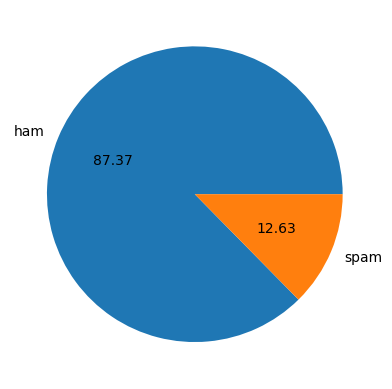

In [19]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")

In [20]:
# data is impalanced

In [22]:
# number of char for each sms
df['num_characters'] = df['text'].apply(len)

# num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

# number of sentences
df['num_sentence'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [26]:
df[['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.453279,1.947185
std,58.236293,13.324793,1.362406
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,28.000000


In [27]:
# describing ham and spam seperately
# ham
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [28]:
# spam
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


<Axes: xlabel='num_characters', ylabel='Count'>

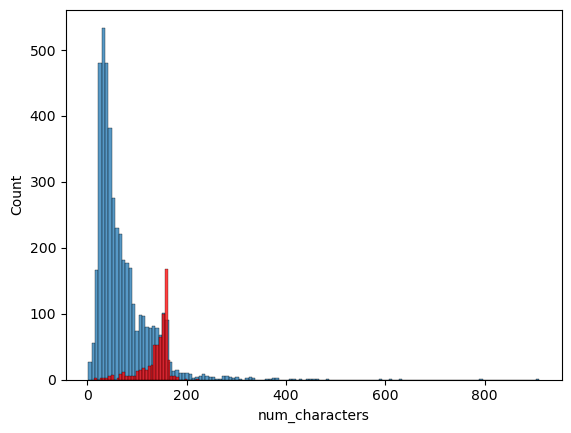

In [29]:
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')


<Axes: xlabel='num_words', ylabel='Count'>

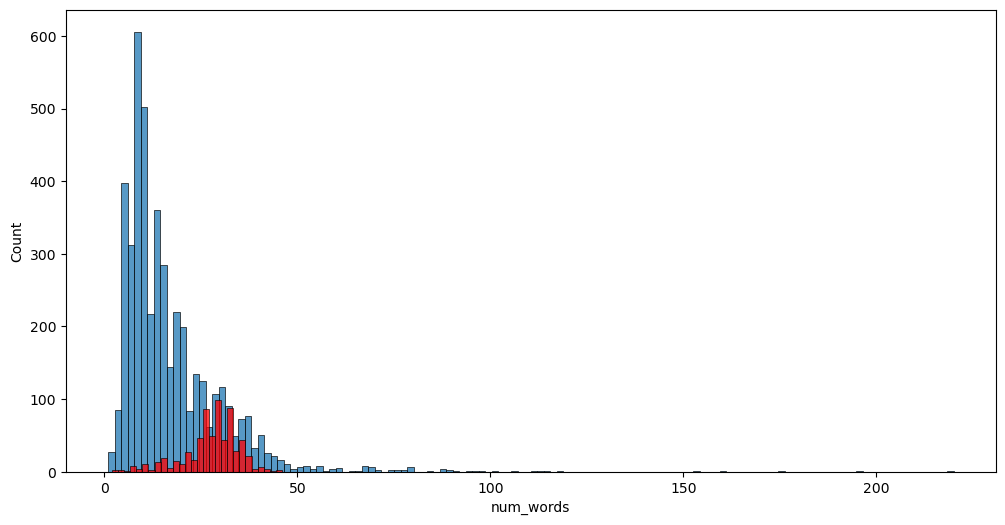

In [30]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'], color='red')


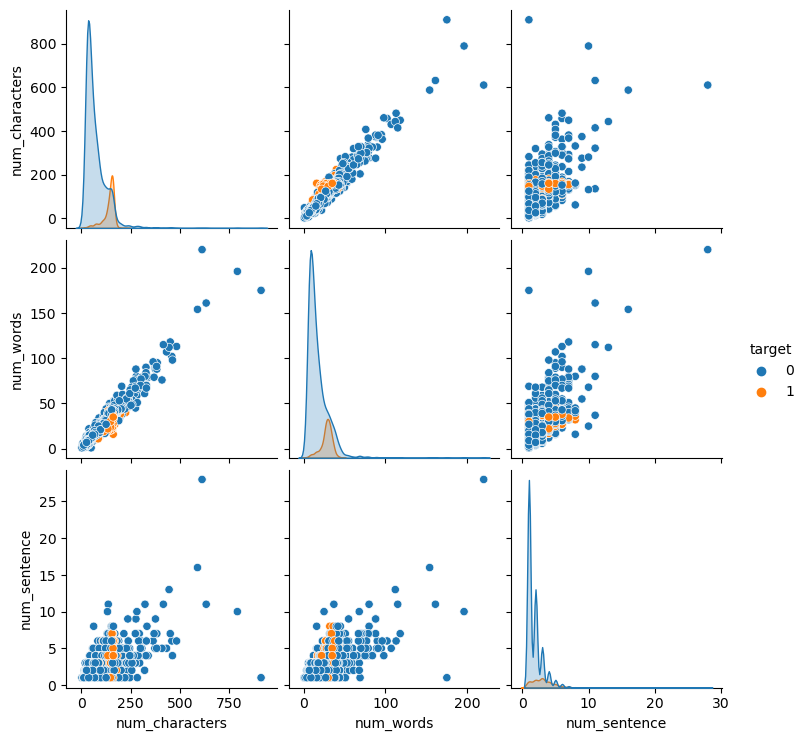

In [31]:
sns.pairplot(df, hue='target')

C:\Users\Dell\AppData\Local\Temp\ipykernel_15868\621126171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

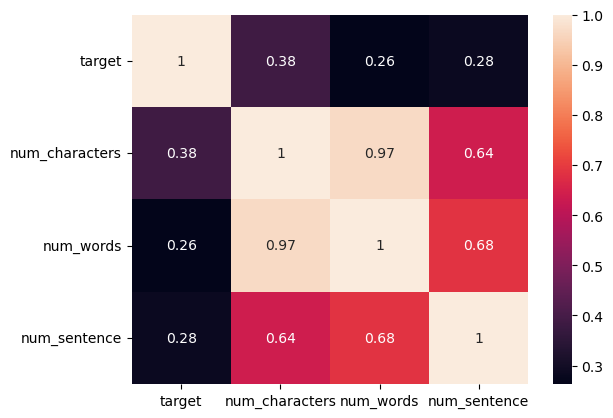

In [32]:
sns.heatmap(df.corr(), annot=True)

In [33]:
# keep the num char column as it has highest corr with target

## Data Preprocessing

- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [103]:
def transform_text(text):
    # lower case
    text = text.lower()
    
    # tokenization
    text = nltk.word_tokenize(text)
    
    # removing special characters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
            
    # cloning y because list is mutable
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

In [36]:
# stopwords.words('english')

# string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [37]:
ps = PorterStemmer()
ps.stem('dance')
# returns danc

ps.stem('loving')
# returns love

# transform text example
transform_text('I Loved the YT lectures on machine learning. How about you?')

'love'

In [39]:
print(df['text'][0])
print(transform_text(df['text'][0]))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
go jurong point crazi avail bugi n great world la e buffet cine got amor wat


In [40]:
df['transformed_text'] = df['text'].apply(transform_text)

In [68]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

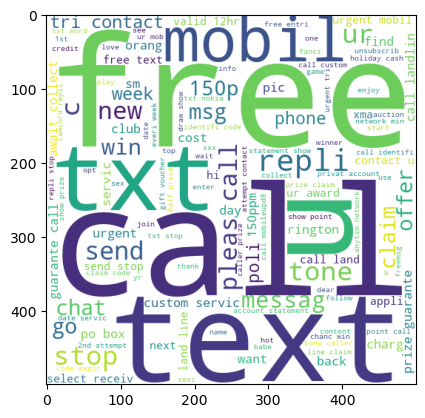

In [43]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

plt.imshow(spam_wc)

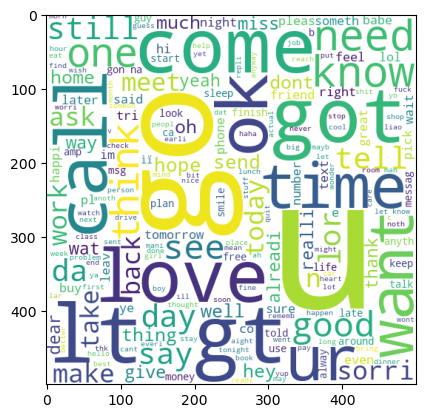

In [67]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc)

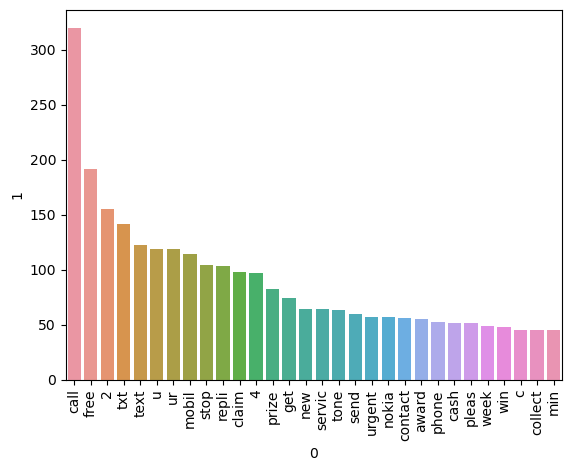

In [69]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
    
len(spam_corpus)

a = pd.DataFrame(Counter(spam_corpus).most_common(30))[0]
b = pd.DataFrame(Counter(spam_corpus).most_common(30))[1]

sns.barplot(x=a, y=b)
plt.xticks(rotation='vertical')
plt.show()

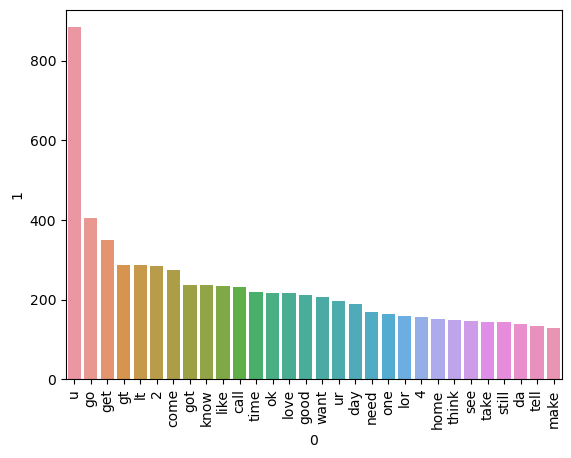

In [48]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
    
    
a = pd.DataFrame(Counter(ham_corpus).most_common(30))[0]
b = pd.DataFrame(Counter(ham_corpus).most_common(30))[1]

sns.barplot(x=a, y=b)
plt.xticks(rotation='vertical')
plt.show()

# Model Building

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [52]:
# naive bayes for text dataset


# cv = CountVectorizer()

# x = cv.fit_transform(df['transformed_text']).toarray()
# y = df['target'].values

# gnb = GaussianNB()
# mnb = MultinomialNB()
# bnb = BernoulliNB()

# gnb.fit(x_train, y_train)
# y_pred1 = gnb.predict(x_test)

# print(accuracy_score(y_test, y_pred1))
# print(confusion_matrix(y_test, y_pred1))
# print(precision_score(y_test, y_pred1))

# mnb.fit(x_train, y_train)
# y_pred2 = mnb.predict(x_test)

# print(accuracy_score(y_test, y_pred2))
# print(confusion_matrix(y_test, y_pred2))
# print(precision_score(y_test, y_pred2))

# bnb.fit(x_train, y_train)
# y_pred3 = bnb.predict(x_test)

# print(accuracy_score(y_test, y_pred3))
# print(confusion_matrix(y_test, y_pred3))
# print(precision_score(y_test, y_pred3))

0.8800773694390716
[[792 104]
 [ 20 118]]
0.5315315315315315


In [95]:
# changing max_features to 3000 words (only observes 3000 most used words)
# after this change mnb is the most precise model
tfidf = TfidfVectorizer(max_features=3000)
x = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

# gnb = GaussianNB()
# mnb = MultinomialNB()
# bnb = BernoulliNB()

# gnb.fit(x_train, y_train)
# y_pred1 = gnb.predict(x_test)
# print(accuracy_score(y_test, y_pred1))
# print(confusion_matrix(y_test, y_pred1))
# print(precision_score(y_test, y_pred1))

# mnb.fit(x_train, y_train)
# y_pred2 = mnb.predict(x_test)
# print(accuracy_score(y_test, y_pred2))
# print(confusion_matrix(y_test, y_pred2))
# print(precision_score(y_test, y_pred2))

# bnb.fit(x_train, y_train)
# y_pred3 = bnb.predict(x_test)
# print(accuracy_score(y_test, y_pred3))
# print(confusion_matrix(y_test, y_pred3))
# print(precision_score(y_test, y_pred3))

In [96]:
# comparing all the models for their accuracy and precision
# naive bayes is the best

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()

# most precise
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)

# bc = BaggingClassifier(n_estimators=50, random_state=2)
# etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
# gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
# xgb = XGBClassifier(n_estimators=50, random_state=2)

clfs = {
    'SVC': svc, 
    'KN': knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'Adaboost': abc, 
#     'Bgc': bc, 
#     'ETC': etc, 
#     'GDBT': gbdt, 
#     'xgb': xgb,
}

In [97]:
# function for predicting models
def train_classifier(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
        
    return accuracy, precision

In [98]:
# loop for comparing different models
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision = train_classifier(clf, x_train, y_train, x_test, y_test)
    
    print("For ", name)
    print('Accuracy', current_accuracy)
    print('Precision', current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy 0.9758220502901354
Precision 0.9747899159663865
For  KN
Accuracy 0.9052224371373307
Precision 1.0
For  NB
Accuracy 0.9709864603481625
Precision 1.0
For  DT
Accuracy 0.9323017408123792
Precision 0.8333333333333334
For  LR
Accuracy 0.9584139264990329
Precision 0.9702970297029703
For  RF
Accuracy 0.9748549323017408
Precision 0.9827586206896551
For  Adaboost
Accuracy 0.960348162475822
Precision 0.9292035398230089


In [94]:
performance_df = pd.DataFrame({'Algorithm': clfs.keys(), 'Accuracy': accuracy_scores, 'Precision': precision_scores})

performance_df

,Algorithm,Accuracy,Precision
0,SVC,0.972921,0.974138
1,KN,0.900387,1.000000
2,NB,0.959381,1.000000
3,DT,0.937137,0.854369
4,LR,0.951644,0.940000
5,RF,0.973888,1.000000
6,Adaboost,0.961315,0.945455


In [100]:
temp_df = pd.DataFrame({'Algorithm': clfs.keys(), 'Accuracy_max_ft_3000': accuracy_scores, 'Precision_max_ft_3000': precision_scores})
performance_df.merge(temp_df, on='Algorithm')

# accuracy increased for nb after max_feature 3000

,Algorithm,Accuracy,Precision,Accuracy_max_ft_3000,Precision_max_ft_3000
0,SVC,0.972921,0.974138,0.975822,0.974790
1,KN,0.900387,1.000000,0.905222,1.000000
2,NB,0.959381,1.000000,0.970986,1.000000
3,DT,0.937137,0.854369,0.932302,0.833333
4,LR,0.951644,0.940000,0.958414,0.970297
5,RF,0.973888,1.000000,0.974855,0.982759
6,Adaboost,0.961315,0.945455,0.960348,0.929204


In [ ]:
# scaling didnt work
# adding num_word, num_sent didnt work
# voting and stacking didnt work

# pipeline is not required as there are 3 steps only
# 1 transforming text/ preprocessing
# 2 vectorize
# 3 applying algo

In [102]:
# wb is write binary
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))